In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [17]:

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [4]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
    # other params...
)

In [5]:
# Define Tavily search Tool 

from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"}]

In [6]:
llm_with_tools = llm.bind_tools(tools)

In [7]:
# from langchain_core.messages import AIMessage

# messages = [
#     (
#         "system",
#         "You are a helpful assistant that translates English to French. Translate the user sentence.",
#     ),
#     ("human", "I love programming."),
# ]
# ai_msg = llm.invoke(messages)


In [18]:
def chatbot(state: State):
    # return {"messages": [llm.invoke(state["messages"])]}
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [19]:
import json

from langchain_core.messages import ToolMessage


# class BasicToolNode:
#     """A node that runs the tools requested in the last AIMessage."""

#     def __init__(self, tools: list) -> None:
#         self.tools_by_name = {tool.name: tool for tool in tools}

#     def __call__(self, inputs: dict):
#         if messages := inputs.get("messages", []):
#             message = messages[-1]
#         else:
#             raise ValueError("No message found in input")
#         outputs = []
#         for tool_call in message.tool_calls:
#             tool_result = self.tools_by_name[tool_call["name"]].invoke(
#                 tool_call["args"]
#             )
#             outputs.append(
#                 ToolMessage(
#                     content=json.dumps(tool_result),
#                     name=tool_call["name"],
#                     tool_call_id=tool_call["id"],
#                 )
#             )
#         return {"messages": outputs}


# tool_node = BasicToolNode(tools=[tool])
# graph_builder.add_node("tools", tool_node)

from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools = [tool])
graph_builder.add_node("tools", tool_node)

In [ ]:
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)
# graph = graph_builder.compile()


from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# graph = graph_builder.compile()

In [25]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

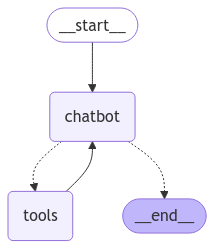

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
config = {"configurable": {"thread_id": "1"}}

In [28]:
graph.invoke({"messages": [("user", "what do i love.")]}, config=config)

{'messages': [HumanMessage(content='I love programming.', additional_kwargs={}, response_metadata={}, id='b5504ea1-e46d-4661-8a7b-adccc66da0ac'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-15T23:23:52.1282528Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1834293800, 'load_duration': 1159883200, 'prompt_eval_count': 192, 'prompt_eval_duration': 159000000, 'eval_count': 21, 'eval_duration': 509000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'programming'}}}]}}, id='run-884b450a-8edf-43df-b87f-e9f9b01c6b53-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'programming'}, 'id': '19a0e7f0-efb6-4891-a5aa-4bd90e4d0e2b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 192, 'output_tokens': 21, 'total_tokens': 213}),
  ToolMessage(content='[{"url": "https://en.wikipedia.org/wi

In [31]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]},config=config, stream_mode='values'):
        # for value in event.values():
        #     print("Assistant:", value["messages"][-1].content)
        # for event in events:
        event["messages"][-1].pretty_print()


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

================================ Human Message =================================

who are you
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6db1630b-991b-4eec-b3aa-0e60048faaf3)
 Call ID: 6db1630b-991b-4eec-b3aa-0e60048faaf3
  Args:
    query: weather in Madurai
  tavily_search_results_json (f37b7727-90d0-4186-a9e3-fbde0d28184b)
 Call ID: f37b7727-90d0-4186-a9e3-fbde0d28184b
  Args:
    query: LangGraph
  tavily_search_results_json (268d5046-68a3-495d-a68a-9d37184566cd)
 Call ID: 268d5046-68a3-495d-a68a-9d37184566cd
  Args:
    query: greeting
  tavily_search_results_json (fae0f462-4d52-4eaf-a2be-94642156ceeb)
 Call ID: fae0f462-4d52-4eaf-a2be-94642156ceeb
  Args:
    query: LangGraph
  tavily_search_results_json (34fed208-77e1-492f-afe2-5b36730758d5)
 Call ID: 34fed208-77e1-492f-afe2-5b36730758d5
  Args:
    query: assistant
================================= Tool Message =================================
Name

In [15]:
graph.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'chatbot': Node(id='chatbot', name='chatbot', data=chatbot(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'tools': Node(id='tools', name='tools', data=tools(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='chatbot', data=None, conditional=False), Edge(source='tools', target='chatbot', data=None, conditional=False), Edge(source='chatbot', target='tools', data=None, conditional=True), Edge(source='chatbot', target='__end__', data=None, conditional=True)])